In [52]:
import numpy as np
import h5py as hp
import sys, os
import PyHEADTAIL
import PyNAFF as pnf
from FITX import fit_risetime
from matplotlib import pyplot as plt
import seaborn as sbs
sys.path.append('/home/vgubaidulin/PhD/Code/Tracking/my_utils_modules/')

In [53]:
from h5_reading_utils import *
from stability_analysis_utils import *
sbs.set(rc={'figure.figsize':(8.3,5.2),
            'text.usetex':True,
           'font.family':'serif',
           'font.size':36,
           'axes.linewidth':2,
           'lines.linewidth':4,
           'legend.fontsize':24,
           'legend.numpoints':1,},
        style='ticks',
        palette='colorblind',
        context='talk')

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
def read_scan_data(folder, is_plane_x=True):
    dQcoh_re = np.load(folder+'dQcoh_real.npy')
    dQcoh_im = np.load(folder+'dQcoh_imag.npy')
    stable_x = []
    stable_y = []
    for index_re, r in enumerate(dQcoh_re):
        for index_im, i in enumerate(dQcoh_im):
            try:
                mean_x, mean_xp, epsn_x, sigma_x, n_turns = get_bunch_data(
                    r, i, folder, is_plane_x)
                signal_x = np.sqrt(mean_x**2+(BETA_X*mean_xp)**2)/sigma_x[0]
                if not(np.isnan(fit_risetime(signal_x,
                                             min_level=MIN_LEVEL,
                                             smoothing_window_size=SMOOTHING_WINDOW_SIZE,
                                             matplotlib_axis=ax))):
                    stable_x.append(r)
                    stable_y.append(i)
            except:
                pass
    return np.array(stable_x), np.array(stable_y)

## Plots for single phase and different damping rates

[-5.0e-04 -4.5e-04 -4.0e-04 -3.5e-04 -3.0e-04 -2.5e-04 -2.0e-04 -1.5e-04
 -1.0e-04 -5.0e-05  0.0e+00  5.0e-05  1.0e-04  1.5e-04  2.0e-04  2.5e-04
  3.0e-04  3.5e-04  4.0e-04  4.5e-04  5.0e-04]
Real coherent tune shift: 5.00e-05
Growth rate: nan
Growth rate: nan
Growth rate: nan
Growth rate: nan
Growth rate: nan
Growth rate: nan
Growth rate: 0.002
Growth rate: 0.009
Growth rate: 0.040
Growth rate: 0.028
Growth rate: 0.024
Growth rate: 0.066
Growth rate: 0.095
Growth rate: 0.025
Growth rate: 0.125
Growth rate: 0.126
Growth rate: 0.148
Growth rate: 0.165
Growth rate: 0.176
Growth rate: 0.186
Growth rate: 0.196
Growth rate: 0.207
Growth rate: 0.217
Growth rate: 0.228
Growth rate: 0.238
Growth rate: 0.248
Growth rate: 0.258
Growth rate: 0.269
Growth rate: 0.279
Growth rate: 0.289
Growth rate: 0.299


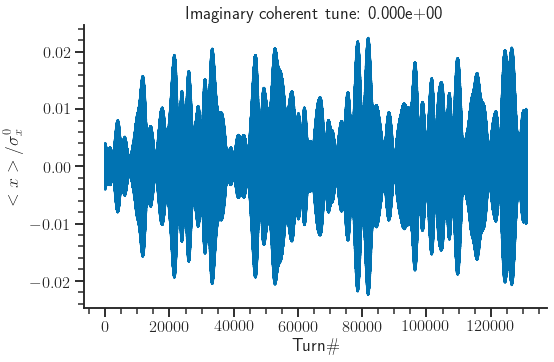

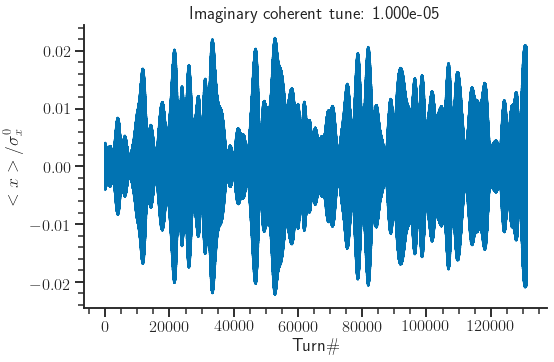

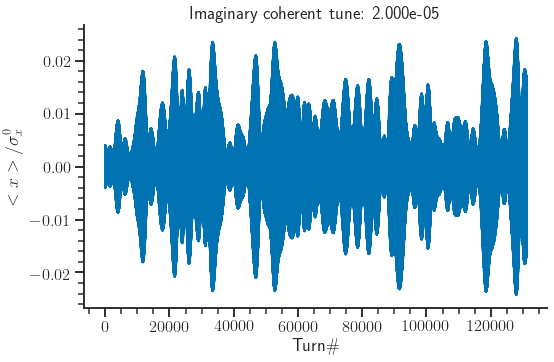

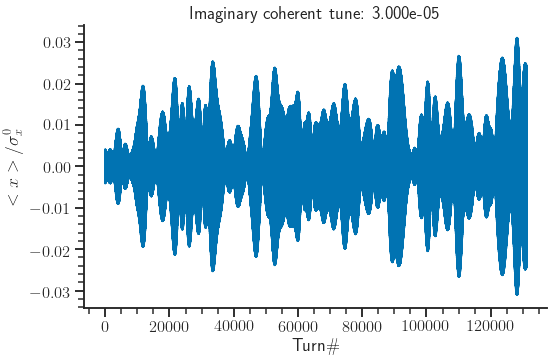

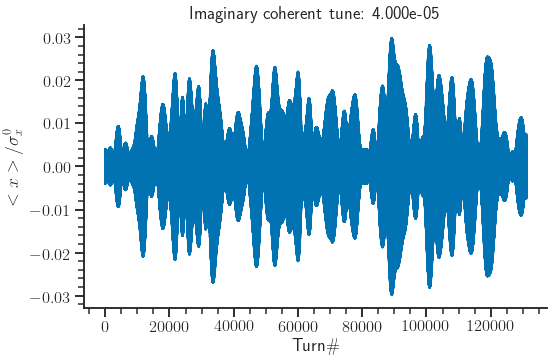

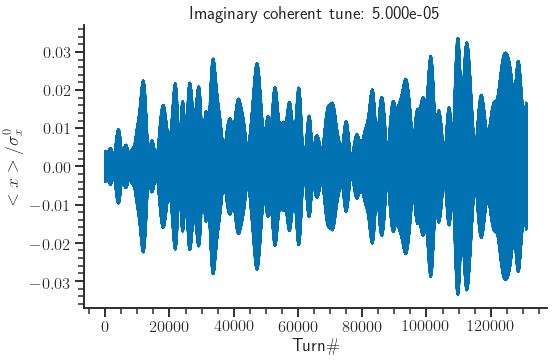

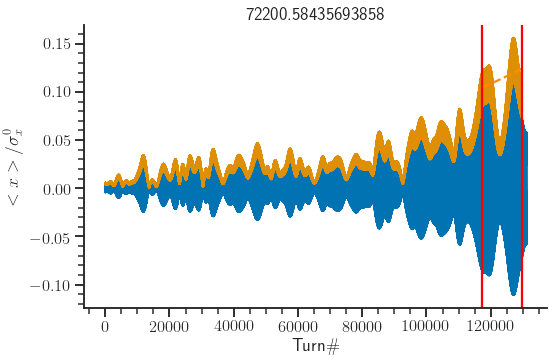

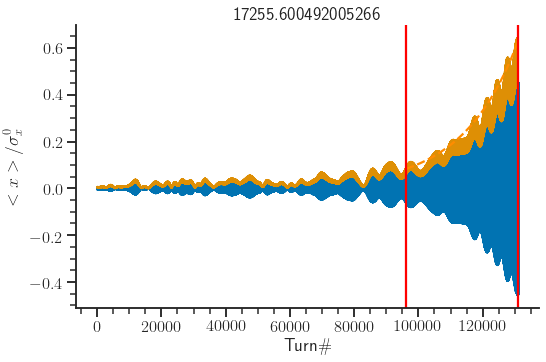

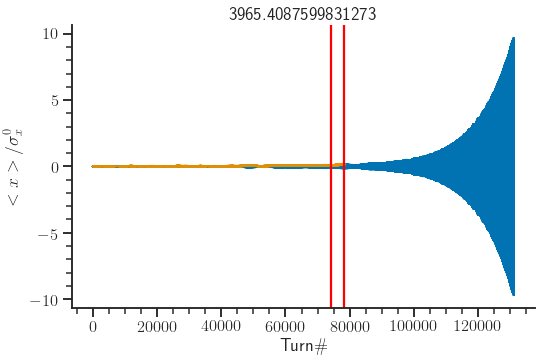

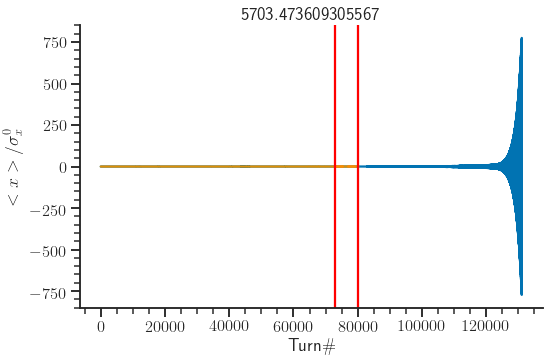

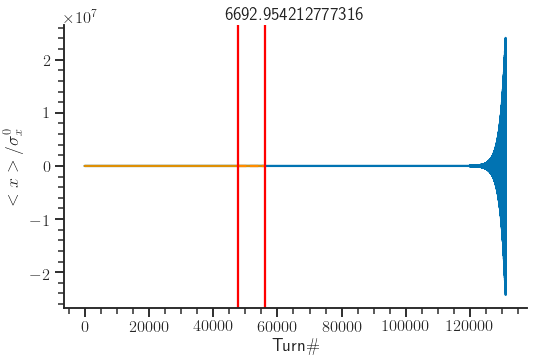

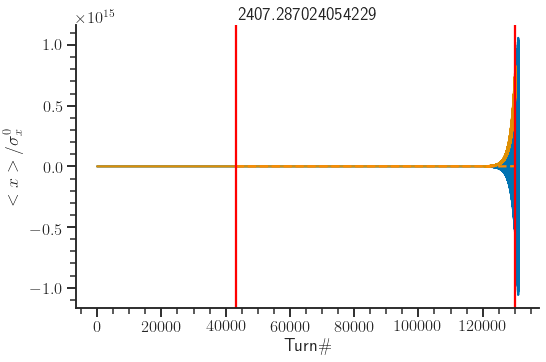

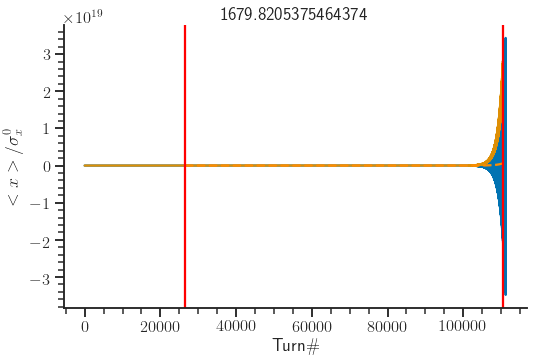

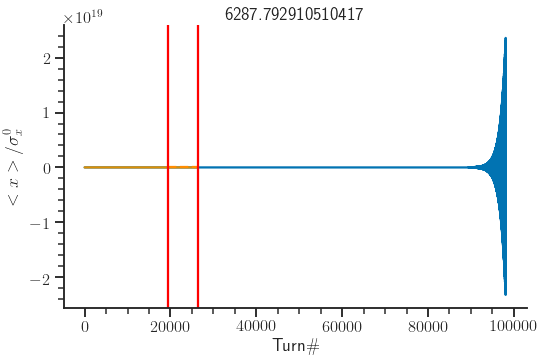

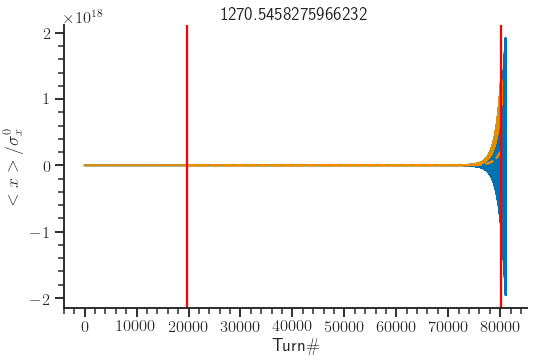

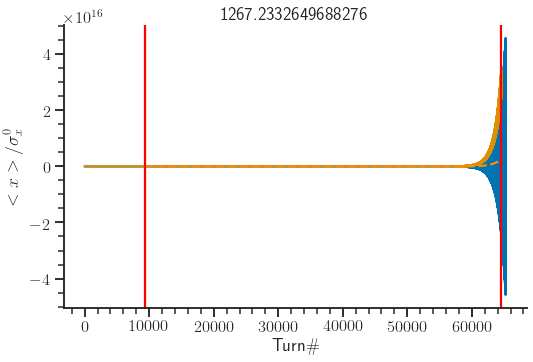

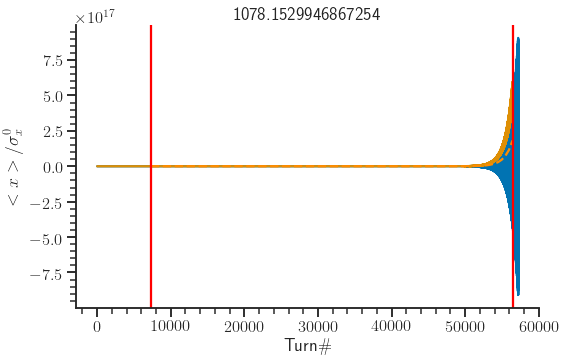

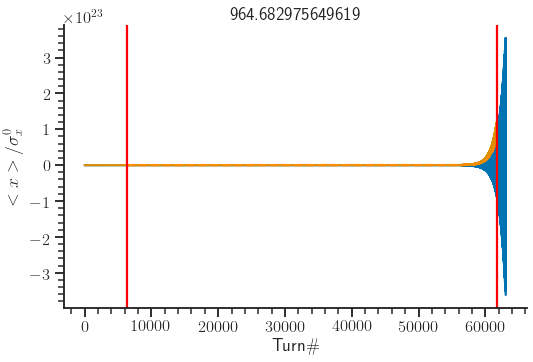

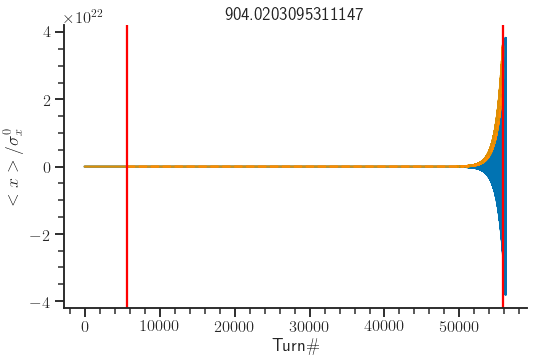

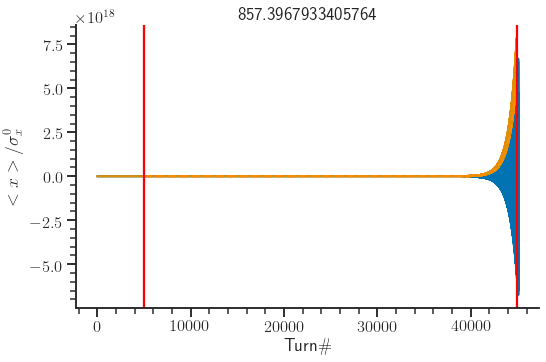

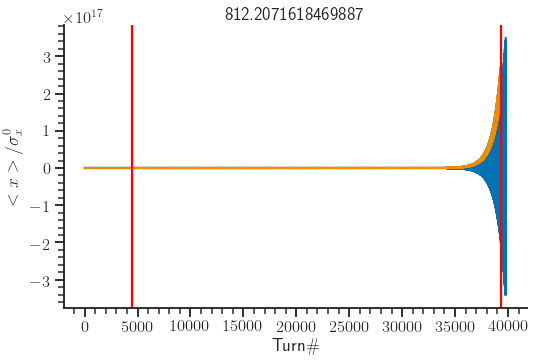

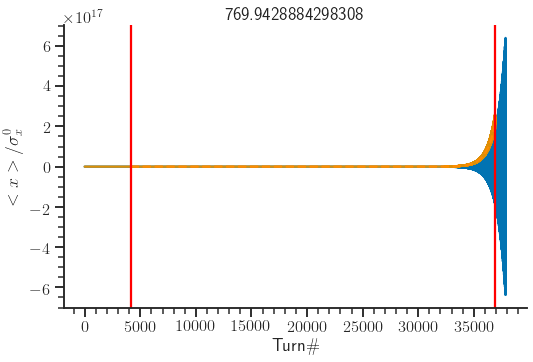

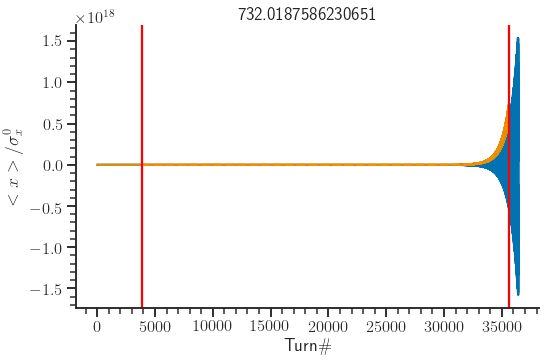

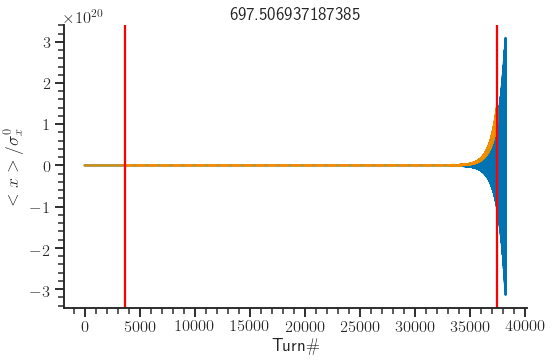

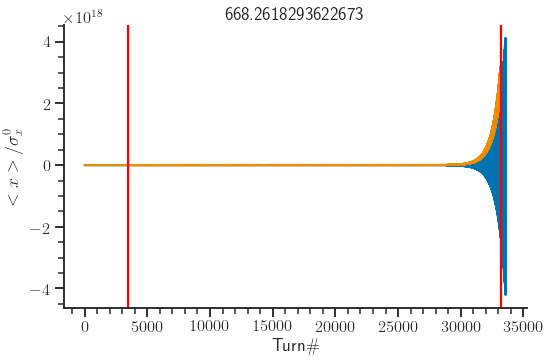

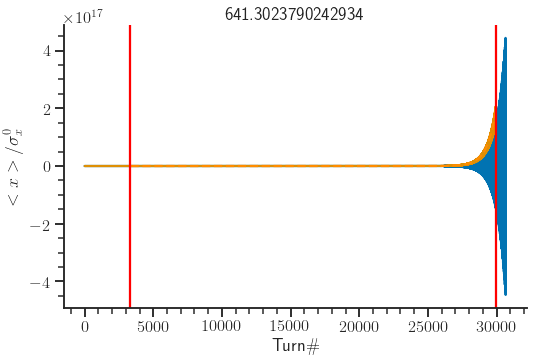

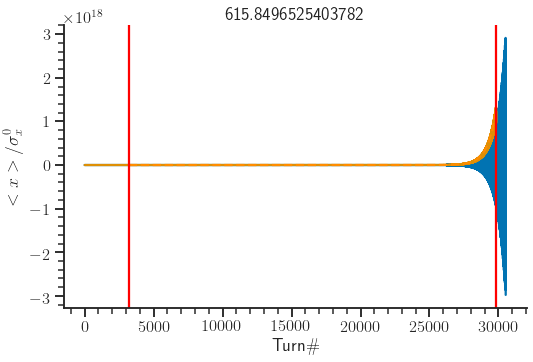

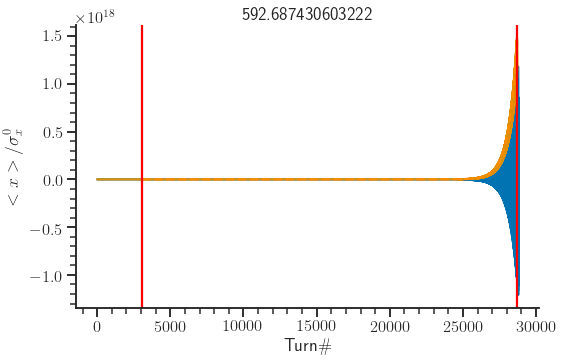

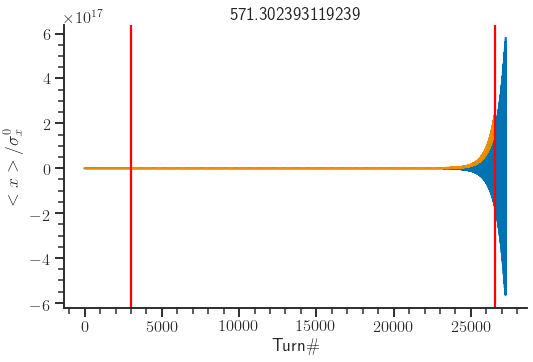

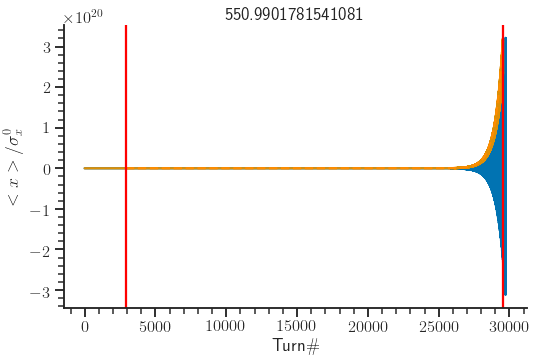

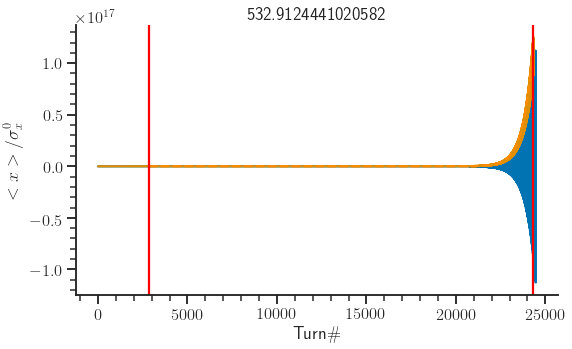

In [90]:
from scipy.constants import c, pi
sbs.set(rc={'figure.figsize':(8.3,5.2)},  style='ticks',
        palette='colorblind',
        context='talk')
folder = '/home/vgubaidulin/PhD/Data/SS/LHC/elens/DC-elens(r=1.4)/'
# folder = '/home/vgubaidulin/PhD/Data/PELanti/PELanti5e-3/'
dQcoh_real = np.load(folder+'dQr.npy')
dQcoh_imag = np.load(folder+'dQi.npy')
print(dQcoh_real)
sbs.set_palette('colorblind')
r = dQcoh_real[11]
print('Real coherent tune shift: {0:.2e}'.format(r))
growth_rates = []
tunes = []
SMOOTHING_WINDOW_SIZE=1024
MIN_LEVEL=0.1
BETA_X=93.2#1080/(0.56*c*2*pi)
for index, i in enumerate(dQcoh_imag):
#     try:
    mean_x, mean_xp, epsn_x, sigma_x, n_turns = get_scanbunch_data(r, i, folder)
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlabel('Turn\#')
    ax1.set_ylabel('$<x>/\sigma^0_x$')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.minorticks_on()
    ax1.set_title('Imaginary coherent tune: {0:.3e}'.format(i))
    ax1.plot(range(n_turns), mean_x/sigma_x[0])
    signal_x = np.sqrt(mean_x**2+(mean_xp*BETA_X)**2)/sigma_x[0]
    rx = fit_risetime(signal_x,
                      min_level=MIN_LEVEL,
                      smoothing_window_size=SMOOTHING_WINDOW_SIZE,
                      matplotlib_axis = ax1)
    if ( (not np.isnan(rx)) and (1/(2*np.pi*rx)) > 1e-5 ):
        growth_rates.append(1/(2*np.pi*rx))
        tunes.append(i)
    print('Growth rate: {0:.3f}'.format(1e3/(2*np.pi*rx)))
#     except:
#         print('Some data is missing')
plt.tight_layout()    
plt.show()

Stability boundary is at 0.045
R-squared score for the model is: 0.986


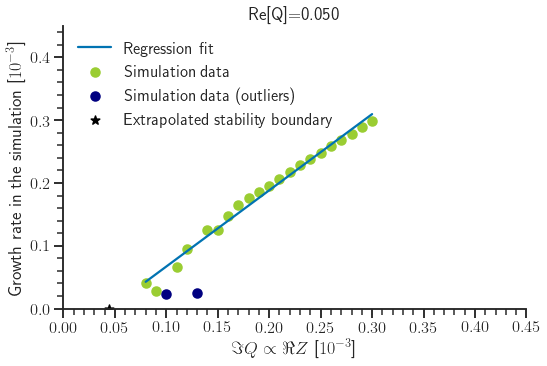

In [91]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score
ransac = RANSACRegressor(stop_score=0.85)
x = np.array(tunes).reshape(-1, 1)/1e-3
y = np.array(growth_rates)/1e-3
sbs.set(rc={'figure.figsize':(8.3,5.2)},  style='ticks',
        palette='colorblind',
        context='talk')
ransac.fit(x, y)
predicted_y = ransac.predict(x)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
fig, ax = plt.subplots()
ax.plot(x, predicted_y)
ax.scatter(x[inlier_mask], y[inlier_mask], marker='o', label='inliers', color='yellowgreen')
ax.scatter(x[outlier_mask], y[outlier_mask], marker='o', label='outliers', color='navy')

stability_boundary = -ransac.estimator_.intercept_/ransac.estimator_.coef_[0] if -ransac.estimator_.intercept_/ransac.estimator_.coef_[0] > 0 else 0
print(r'Stability boundary is at {0:.3f}'.format(stability_boundary))
r2 = r2_score(ransac.predict(x[inlier_mask]), y[inlier_mask])
print(r'R-squared score for the model is: {0:.3f}'.format(r2))
ax.scatter(stability_boundary, 0, marker='*', color='black')
ax.set_xlim(0., 0.45)
ax.set_ylim(0., 0.45)
ax.title.set_text('Re[Q]={0:.3f}'.format(r*1e3))
ax.set_ylabel('Growth rate in the simulation [$10^{-3}$]')
ax.set_xlabel(r'$\Im{Q}\propto\Re{Z}$ [$10^{-3}$]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.minorticks_on()
plt.legend(( 'Regression fit',
               'Simulation data',
               'Simulation data (outliers)',
               'Extrapolated stability boundary'),
              loc='upper left', frameon=False)
plt.show()

## Stability diagram reconstruction

In [92]:
dQcoh_real = np.load(folder+'dQr.npy')
dQcoh_imag = np.load(folder+'dQi.npy')
def get_growth_rates(dQcoh_real, dQcoh_imag, folder):
    growth_rates = np.zeros(shape=(len(dQcoh_real), len(dQcoh_imag)), dtype=np.float64)
    tunes = np.zeros(shape=(len(dQcoh_real), len(dQcoh_imag)), dtype=np.float64)
    for r_index, r in enumerate(dQcoh_real):
        for i_index, i in enumerate(dQcoh_imag):
            mean_x, mean_xp, epsn_x, sigma_x, n_turns = get_scanbunch_data(r, i, folder)
            signal_x = np.sqrt(mean_x**2+(BETA_X*mean_xp)**2)/sigma_x[0]
            rx = fit_risetime(signal_x,
                              min_level=MIN_LEVEL,
                              smoothing_window_size=SMOOTHING_WINDOW_SIZE)
            if ( (not np.isnan(rx)) and rx > 0):
                growth_rates[r_index, i_index] = 1/(2*np.pi*rx)
                tunes[r_index, i_index] = i
            else:
                growth_rates[r_index, i_index] = None
                tunes[r_index, i_index] = tunes[r_index, i_index-1]
    return growth_rates, tunes
growth_rates, tunes = get_growth_rates(dQcoh_real, dQcoh_imag, folder)

In [93]:
%%time
def get_stability_point(tunes, growth_rates):
    x = np.array(tunes).reshape(-1, 1)/1e-3
    y = np.array(growth_rates)/1e-3
    ransac = RANSACRegressor(stop_score=0.85)
    try:
        ransac.fit(x, y)
        predicted_y = ransac.predict(x)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        point = -ransac.estimator_.intercept_/ransac.estimator_.coef_[0]
        stability_boundary = point if point > 0 else None
        r2 = r2_score(ransac.predict(x[inlier_mask]), y[inlier_mask])
        if ransac.estimator_.coef_[0] < 0:
            stability_boundary = None
    except:
        stability_boundary = None
        r2 = -42
    
    return stability_boundary, r2

number_of_iterations = 1000
stability_boundary = np.zeros(shape=(2, len(dQcoh_real), number_of_iterations), dtype=np.float64)
for n in range(number_of_iterations): 
    for r_index, r in enumerate(dQcoh_real):
        Qs = tunes[r_index, :]
        grates = growth_rates[r_index, :] 
        i_index = np.where(grates > 0)[0]
        Qs = tunes[r_index, i_index]
        grates = growth_rates[r_index, i_index]
        stab_point, r2 = get_stability_point(Qs, grates)
        stability_boundary[:, r_index, n] = (r, stab_point) if stab_point != None else (r, stability_boundary[1, r_index, n-1])
stab_x = np.zeros(shape=(len(dQcoh_real),))
stab_y = np.zeros(shape=(len(dQcoh_real),))
for r_index, r in enumerate(dQcoh_real):
    for i_index, i in enumerate(dQcoh_imag):
        stab_x[r_index] = np.mean(stability_boundary[0, r_index, :])
        stab_y[r_index] = np.mean(stability_boundary[1, r_index, :])

CPU times: user 35.5 s, sys: 107 ms, total: 35.6 s
Wall time: 35.6 s


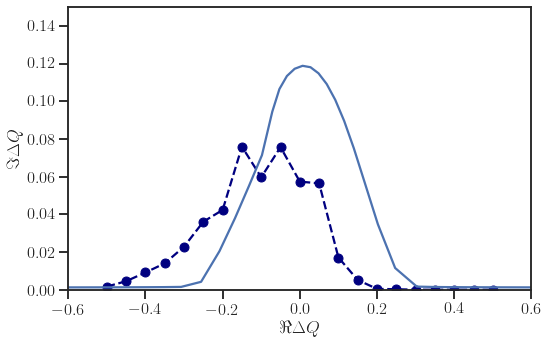

In [94]:
import os
sbs.set(rc={'figure.figsize':(8.3,5.2)}, context='talk', style='ticks')

plt.plot(stab_x/1e-3, stab_y, marker='o', color='navy', linestyle='--')

dQre = np.load('/home/vgubaidulin/PhD/Data/DR/DC-elens(r=1.4)/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/DR/DC-elens(r=1.4)/dQim.npy')
plt.plot(dQre/1e-3, dQim/1e-3)

plt.xlim(-.6, .6)
plt.ylim(0, .15)
plt.xlabel(u'$\Re{\Delta Q}$')
plt.ylabel(u'$\Im{\Delta Q}$')
# os.mkdir('/home/vgubaidulin/PhD/Data/RSD/SIS100PEL(dQ=0.005)')
# np.save('/home/vgubaidulin/PhD/Data/RSD/SIS100PEL(dQ=0.005)/dQre.npy', stab_x)
# np.save('/home/vgubaidulin/PhD/Data/RSD/SIS100PEL(dQ=0.005)/dQim.npy', stab_y*1e-3)
# plt.legend(('$\Delta Q_\mathrm{max} = 0.001$',))
plt.show()